In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data = np.array([
["Soleado", "Calor", "Alta", "No", "N"],
["Nublado", "Calor", "Alta", "No", "P"],
["Lluvioso", "Templado", "Alta", "No", "P"],
["Lluvioso", "Frío", "Normal", "No", "P"],
["Lluvioso", "Frío", "Normal", "Sí", "N"],
["Nublado", "Frío", "Normal", "Sí", "P"],
["Soleado", "Templado", "Alta", "No", "N"],
["Soleado", "Frío", "Normal", "No", "P"],
["Lluvioso", "Templado", "Normal", "No", "P"],
["Soleado", "Templado", "Normal", "Sí", "P"],
["Soleado", "Calor", "Alta", "Sí", "N"],
["Nublado", "Templado", "Alta", "Sí", "P"],
["Nublado", "Calor", "Normal", "No", "P"],
["Lluvioso", "Templado", "Alta", "Sí", "N"],
])


In [3]:
X = data[:,0:4]
y = data[:,4]

In [4]:
class Nodo:

	def __init__(self, nombre, padre, arista=None):
		self.nombre = nombre
		self.padre  = padre
		self.hijos  = []
		self.arista = arista

	def agregar_hijo(self, hijo):
		self.hijos.append(hijo)

	def regresar_hijo(self, arista):
		for hijo in self.hijos:
			if hijo.arista == arista:
				return hijo
		return None

In [5]:
import numpy as np


class ID3_C:

	def __init__(self):
		self.raiz        = None
		self.atributos   = None

	def crear_nodo(self, nombre, padre, arista=None):
		return Nodo(nombre, padre, arista)

	def establecer_atributos(self, atributos):
		self.atributos = atributos

	def instancia_mas_abundante(self, Y):
		unicos, cuenta = np.unique(Y, return_counts=True)
		cuenta         = cuenta.tolist()
		return unicos[cuenta.index(max(cuenta))]

	def entrenar(self, X, Y):

		# Establecemos etiquetas por defecto.
		if self.atributos is None:
			self.atributos = [str(x) for x in range(X.shape[1])]

		# Checamos si solo existe una clase.
		if np.all(Y == Y[0]):
			self.raiz = self.crear_nodo(Y[0], None)
		
		# De lo contrario buscamos el nodo raíz.
		else:
			atributo         = self.seleccionar_atributo(X, Y, [])
			nombre_raiz      = self.atributos[atributo]
			self.raiz        = self.crear_nodo(nombre_raiz, None)

			# Encontramos los hijos del nodo raiz.
			self.encotrar_hijos(X, Y, atributo, [atributo], self.raiz)

	def encotrar_hijos(self, X, Y, atributo, antecedente, nodo_actual):

		columna_atributo = X[:, atributo]
		valores_unicos   = np.unique(columna_atributo).tolist()
		for valor in valores_unicos:
			x = X[columna_atributo == valor]
			y = Y[columna_atributo == valor]

			# Checamos si nos quedamos sin atributos.
			if len(antecedente) == X.shape[1]:
				instancia = self.instancia_mas_abundante(y)
				hijo      = self.crear_nodo(instancia, nodo_actual, valor)
				nodo_actual.agregar_hijo(hijo)

			# Checamos si solo existe una clase.
			elif np.all(y == y[0]):
				hijo = self.crear_nodo(y[0], nodo_actual, valor)
				nodo_actual.agregar_hijo(hijo)

			# Seleccionamos mejor atributo y llamamos recursivamente.
			else:
				hijo             = self.seleccionar_atributo(x, y, antecedente)
				nombre_hijo      = self.atributos[hijo]
				nodo_hijo        = self.crear_nodo(nombre_hijo, nodo_actual, valor)
				nodo_actual.agregar_hijo(nodo_hijo)
				self.encotrar_hijos(x, y, hijo, antecedente + [hijo], nodo_hijo)
			
	def seleccionar_atributo(self, X, Y, antecedente):

		ganancia = []
		for i, atributo in enumerate(X.T):
			if i not in antecedente:
				ganancia.append(self.calcular_ganancia(atributo, Y))
			else:
				ganancia.append(float("-inf"))
		return ganancia.index(max(ganancia))

	def calcular_ganancia(self, atributo, Y):

		entropia_atributos = 0
		for valor in np.unique(atributo):
			y          = Y[atributo == valor]
			proporcion = y.size/Y.size
			entropia_atributos +=  proporcion * self.calcular_entropia(y)
		return self.calcular_entropia(Y) - entropia_atributos

	def calcular_entropia(self, Y):

		entropia = 0
		for valor in np.unique(Y):
			y           = Y[Y == valor]
			proporcion  = y.size/Y.size
			entropia   -= proporcion * np.log2(proporcion)
		return entropia

	def predecir(self, X):

		Y = np.empty(X.shape[0], dtype="<U10")
		for i, fila in enumerate(X):
			Y[i] = self.predecir_fila(fila)
		return Y

	def predecir_fila(self, fila):

		nodo_actual = self.raiz
		while nodo_actual.hijos: 
			atributo         = nodo_actual.nombre
			columna_atributo = self.atributos.index(atributo)
			valor_atributo   = fila[columna_atributo]
			nodo_actual      = nodo_actual.regresar_hijo(valor_atributo)
		return nodo_actual.nombre

In [6]:
X_train = data[0:10:,0:4]
Y_train = data[0:10:,4]

X_test = data[10:14:,0:4]
Y_test = data[10:14:,4]

arbol = ID3_C()
arbol.entrenar(X_train, Y_train)
salida = arbol.predecir(X_test)
print(salida)
print('Porcentaje de aciertos: ', 100 * sum(Y_test == salida)/X_test.shape[0])

['N' 'P' 'P' 'N']
Porcentaje de aciertos:  100.0


<Axes: >

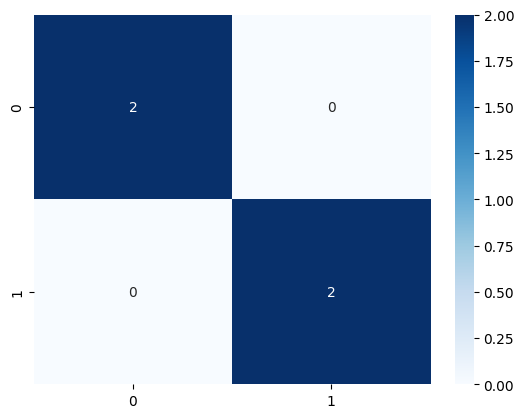

In [7]:
cm = confusion_matrix(Y_test, salida)
sns.heatmap(cm, annot = True, cmap="Blues")